# Project: Product Demand Forecast

**<font size=3> Estrategia Adotada </font>**

A Estrategia adotada foi encontrar a quantidade de items que seriam vendidos para cada um dos produtos, listandos no dataset, nos meses de Junho, Julho e Agosto.

Para essa estrategia, a tatica que eu utilizei foi estruturar esse desafio como um problema de Regressao com Variacao no Tempo. ( Multivariate Regression Analysis ).

**Para encontrar a quantidade de items que seriam vendidos, eu assumi algumas hipoteses:**

    1. O valor final de vendas para cada produto em cada mes sera a soma das vendas diarias de cada produto em cada um dos 3 meses.
    2. Devido as variaveis de grande impacto nas vendas e que podem sofrer alteracoes diarias, como o preco, a granularidade mais indicada eh Item-Dia.
    3. Os produtos possuem uma similaridade em termo da performance de vendas. Portanto, podem existir produtos de diferentes categorias que sao parecidos em termos de suas performance de vendas.
    4. Existe produtos semelhantes em termo de suas performance de vendas ao longo do tempo.
    5. Um modelo de previsao de vendas para cada grupo de produtos semelhantes em termos da peformance de vendas, funciona melhor do que um unico modelo para prever a venda de todos os produtos.


A estrategia que eu adotei para resolver esse desafio pode ser resumida nos seguintes passos.

---------------------------------------------------------------------------------
**<font size=3> 01. Descricao dos dados do arquivo "desafio.csv"</font>**

O Descricao dos Dados tem 2 objetivos: 

    1. Primeiro, conhecer caracteristicas intrinsecas do conjunto de dados como dimensoes, foirmatos e dados faltantes.
    2. O Segundo objetivo eh identificar algumas "falhas" nos dados, atraves de metricas da estatistica de primeira ordem, devido a possiveis falhas no armazenamento dos dados.

As tarefas realizas foram as seguintes: 

    1. Dimensao dos Dados.
    2. Tipo dos Dados nas Colunas.
    3. Volume de Dados Faltantes NA's.
    4. Estatistica Descritiva

**<font size=3> 02. Clustering </font>**

O objetivo do Clustering eh agrupar os produtos com performance de vendas similares dentro de grupos. 

    1. O algoritmo de agrupamento utilizado foi o Hierarquical Clustering Agglomerative Clustering com Complete Linkage.
    2. A medida de distancia usada para agrupar os produtos foi a Dynamic Time Warping ( DTW ).
    3. O criterio usado para medir a qualidade do agrupamento foi a medida da Silhouette.


**<font size=3> 03. Feature Engineering</font>**

O objetivo do Feature Engineering eh derivar novas features a partir das variaveis originais.
Foram criados atributos considerando:

    1. Atributos de Machine Learning.
    2. Data comemorativas e feriados do varejo tradicional no Brasil.


**<font size=3> 04. Analise Exploratoria de Dados ( EDA )</font>**

O objetivo da Analise Exploratoria de Dados ( EDA ) eh encontrar variaveis com forte correlacao.

**<font size=3> 05. Data Preparation </font>**

O objetivo da fase de preparacao dos dados eh converter variaveis categoricas em numericas, aplicando encoding ou transformacoes.

**<font size=3> 06. Feature Selection </font>**

Used Boruta algorithms to select the features most relevant to the model.

**<font size=3> 07. Machine Learning Model </font>**

Implementacao de 6 modelos de Machine Learning

**<font size=3> 08. Hyperparameter Fine Tuning </font>**

Implemented Search algorithm to define the Parameters

**<font size=3> 09. Error Understanding  </font>**

Understanding the Error from Business and Machine Learning Perspectives.

---------------------------------------------------------------------------------
**<font size=3> Resultados </font>**

Esse desafio possui 2 desafios:

    1. Agrupar os produtos utilizando um algoritmo de Machine Learning Nao-Supervisionado.
    2. Definir o Numero de Items que serao vendidos nos meses de Junho, Julho e Agosto para cada produto do conjunto de dados.
    
O Resultado do desafio de agrupamento ficou muito ruim. O algoritmo encontrou apenas 2 clusters sendo que 99% dos produtos pertencem ao cluster 1 e 1% ao cluster 2.

Esse resultado ruim pode ser causado devido aos diferentes comprimentos das Time Series que representam a performance venda. Aparentemente, o banco de dados nao grava dias que nao houveram 
compras, logo se um produto nao teve nenhuma venda em determinados dias, voce tem muitos dias sem vendas.

Essa diferenca de comprimento nas Series Temporais pode estar causando o agrupamento dos produtos em apenas 2 grupos.

Os proximos passos para melhorar o algoritmo de agrupamento seria:

    1. Igualar o tamanho das Series Temporais usando um funcao para comprar dias de nao venda em todos os produtos.
    2. Usar outra estrategia de agrupamento. Gerando novos atributos de interesse ( performance, valor gasto, custo, etc ) e entao usando outros algoritmos de agrupamento.
    
   
O Resultado do desafio de predizer o numero de items que serao vendidos nos meses de Junho, Julho e Agosto nao foi completado.

O script contido nesse projeto prediz valores dos produtos para os meses contidos no conjunto de dados original, separado em um conjunto de dados teste. O algoritmo nao generaliza para meses 
fora do conjunto de dados.

Os  proximos passos para melhorar o algoritmo de predicao seria:

    1. Abstrair todas as tarefas de limpeza, enconding, tranformation em uma classe ou funcao, a fim de ser aplicada sobre os dados novos.
    2. Aplicar o algoritmo sobre os novos dados.


---------------------------------------------------------------------------------
**<font size=3> Vantagens e Desvantagem da Estrategia Adotada </font>**

A estrategia adotada nesse projeto possui algumas vantagens e desvantagens:

**Vantagens:**

    1. O modelo pode ser "pilotado" pelo time de negocio, pois ele possui abertura para inputs de negocio, como o preco, por exemplo.
    
    2. Ha a possibilidade de medir o "impacto" de cada variavel sobre as vendas, o que possibilita identificar possivel causas de baixa performance nas vendas dos produtos.
        
        
**Desvantagens:**

    1. O preco de venda de cada produto precisa ser devido no momento da compra para restoque. Essa atividade mandatoria pode causar um processo adicional, a nao ser que a precificacao seja 
        feita por uma modelo de Machine Learning.

## 0.1. IMPORTS

In [69]:
import warnings
import pandas as pd
import numpy  as np
import random

from fastdtw import fastdtw

import seaborn as sns
import xgboost as xgb

from matplotlib            import pyplot as plt
from boruta                import BorutaPy
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error, silhouette_score
from sklearn.cluster       import AgglomerativeClustering
from sklearn.ensemble      import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings( 'ignore' )

## 0.2. Helper Functions

In [3]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['capture_date'].max() - datetime.timedelta( days=k*30)
        validation_end_date = x_training['capture_date'].max() - datetime.timedelta( days=(k-1)*30)

        # filtering dataset
        training = x_training[x_training['capture_date'] < validation_start_date]
        validation = x_training[(x_training['capture_date'] >= validation_start_date) & (x_training['capture_date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['capture_date', 'quantity'], axis=1 ) 
        ytraining = training['quantity']

        # validation
        xvalidation = validation.drop( ['capture_date', 'quantity'], axis=1 )
        yvalidation = validation['quantity']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, yvalidation, yhat )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def calc_smooth_mean( df, by, on , m ):
    # compute the global mean
    mean = df[on].mean()
    
    # compute the number of values and the mean of each group
    agg = df.groupby( by )[on].agg( ['count', 'mean'] )
    counts = agg['count']
    means = agg['mean']
    
    # compute the "smoothed" means
    smooth = ( counts * means + m * mean ) / ( counts + m )
    
    # replace each value by the according smoothed mean
    return df[by].map( smooth )



def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )



def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] ) 
    
    
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.3. Loading Dataset

In [5]:
df_raw = pd.read_csv( '../data/data_labs.csv' )

# 1.0. DESCRICAO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 179149
Number of Cols: 14


## 1.2. Data Types

In [8]:
df1.dtypes

order_id             object
code                 object
quantity              int64
price               float64
pis_cofins          float64
icms                float64
tax_substitution    float64
category             object
liquid_cost         float64
order_status         object
capture_date         object
process_date         object
process_status       object
source_channel       object
dtype: object

## 1.3. Check NA

In [9]:
df1.isna().sum()

order_id            0
code                0
quantity            0
price               0
pis_cofins          0
icms                0
tax_substitution    0
category            0
liquid_cost         0
order_status        0
capture_date        0
process_date        0
process_status      0
source_channel      0
dtype: int64

## 1.4. Change Data Types

In [10]:
# Date format
df1['capture_date'] = pd.to_datetime( df1['capture_date'] )

df1.loc[df1['process_date'] == '0000-00-00', 'process_date'] = '1900-01-01'
df1['process_date'] = pd.to_datetime( df1['process_date'] )

## 1.5. Change Data Values

In [11]:
# Category
old_category = list( df1['category'].drop_duplicates() )
new_category = [ 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11' ]
category_de_para = dict( zip( old_category, new_category ) ) 
df1['category'] = df1['category'].map( category_de_para )

# Produts ( code )
old_products = list( df1['code'].drop_duplicates() )
new_products = ['P' + str( i ) for i in np.arange( 100, 232 )]
code_de_para = dict( zip( old_products, new_products ) )
df1['code'] = df1['code'].map( code_de_para )

# Source Channel
old_channel = list( df1['source_channel'].drop_duplicates() )
new_channel = ['channel' + str( i ) for i in np.arange( 1, 17 ) ]
channel_de_para = dict( zip( old_channel, new_channel ) )
df1['source_channel'] = df1['source_channel'].map( channel_de_para )

# Order Id
old_order = list( df1['order_id'].drop_duplicates() )
new_order = [i for i in np.arange( 1, 175576 )]
order_de_para = dict( zip( old_order, new_order ) )
df1['order_id'] = df1['order_id'].map( order_de_para )

## 1.6. Granularity

In [12]:
# Sales by Day
cols_agg = list( df1.drop( 'quantity', axis=1 ).columns )
df1 = df1.groupby( cols_agg ).sum().reset_index()

## 1.7. Descriptive Statistics

### 1.7.1. Numerical

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

In [14]:
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,order_id,1.0000,175575.0000,175574.0000,86889.706507,86453.0000,50826.045423,0.018787,-1.201953
1,price,1.0300,19993.0000,19991.9700,234.638585,194.4000,186.638398,27.109077,2125.723778
2,pis_cofins,0.0000,1849.3525,1849.3525,19.525329,17.5195,17.402772,22.766807,1777.300240
3,icms,0.0000,3598.7400,3598.7400,25.095547,21.4920,32.333136,14.203649,1096.176530
4,tax_substitution,0.0000,280.8342,280.8342,17.872443,0.0000,28.125583,2.211765,8.212045
5,liquid_cost,4.1141,896.6814,892.5673,136.034906,117.0820,83.603010,2.066601,8.568905
6,quantity,1.0000,100.0000,99.0000,1.055278,1.0000,0.597940,60.085256,6821.090621


### 1.7.2. Categorical

In [15]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

code              131
category           11
order_status       17
process_status      2
source_channel     16
dtype: int64

### 1.7.3. Temporal

In [16]:
print( 'Capture Date - Min Date: {}'.format( time_attributes.min()[0] ) )
print( 'Capture Date - Max Date: {}'.format( time_attributes.max()[0] ) )


print( '\nProcess Date - Min Date: {}'.format( time_attributes.min()[1] ) )
print( 'Process Date - Max Date: {}'.format( time_attributes.max()[1] ) )

Capture Date - Min Date: 2016-06-01 00:00:00
Capture Date - Max Date: 2017-06-01 00:00:00

Process Date - Min Date: 1900-01-01 00:00:00
Process Date - Max Date: 2017-07-11 00:00:00


# 2.0. CLUSTERING

In [17]:
df2 = df1.copy()

In [18]:
# Distance Matrix
dim_matrix = df2['code'].drop_duplicates().shape[0]
distance_matrix = np.zeros( (dim_matrix, dim_matrix) )

for i in range( 0, 131 ):
    p1 = df2[df2['code'] == 'P' + str( i+100 )]['quantity'].values
    for j in range( 0, 131 ):
        p2 = df2[df2['code'] == 'P' + str( j+100 )]['quantity'].values
        
        distance, path = fastdtw( p1, p2 )
        distance_matrix[i][j] = distance

## 2.1. Number of Clustering

In [19]:
max_clusters = 15
clusters = np.arange( 2, max_clusters+1 )

silhouettes = []
for c in clusters:
    model = AgglomerativeClustering( affinity='precomputed',  n_clusters=c,  linkage='complete' ).fit( distance_matrix )
    s = silhouette_score( distance_matrix, model.fit_predict( distance_matrix ) )
    silhouettes.append( s )

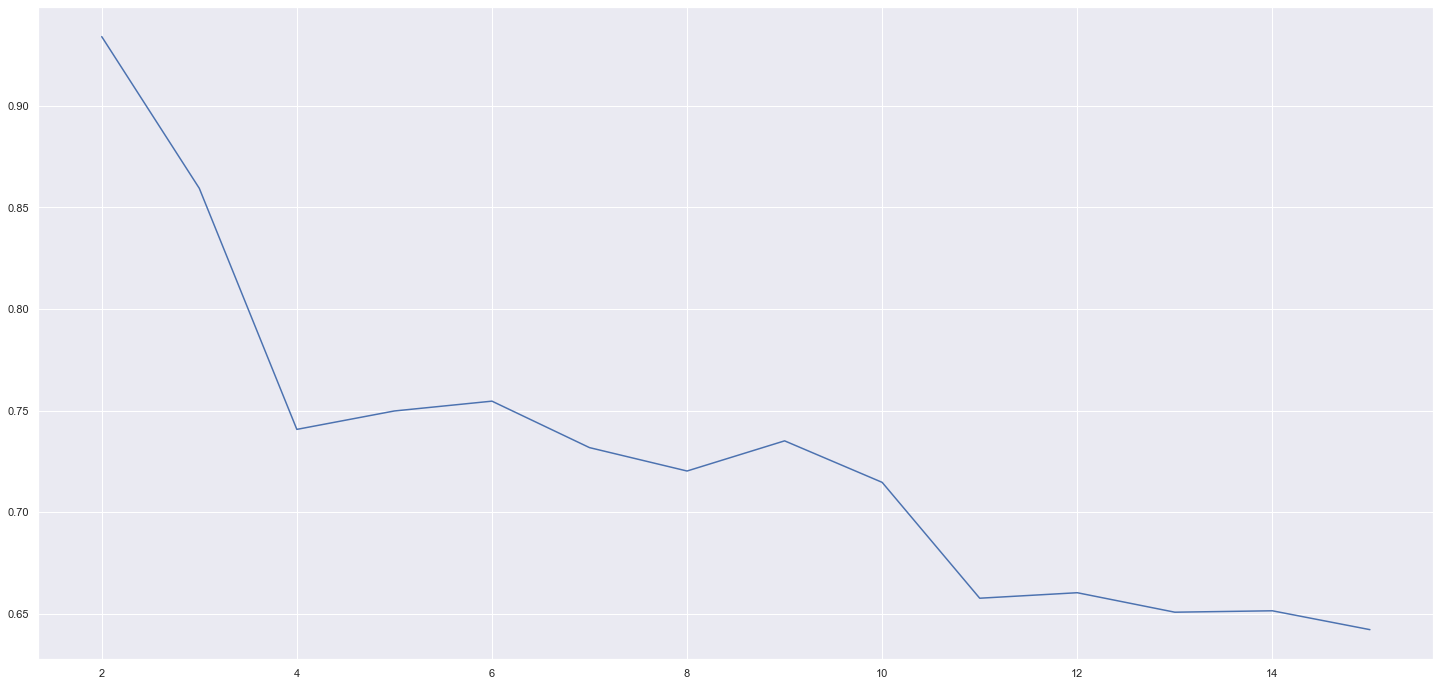

In [20]:
sns.lineplot( clusters, silhouettes )

## 2.2. Final Clustering

In [21]:
model = AgglomerativeClustering( affinity='precomputed',  n_clusters=2,  linkage='complete' ).fit( distance_matrix )
clusters = model.labels_

# Assign every produto to a cluster
products = ['P' + str( i ) for i in np.arange( 100, 232 )]
cluster_de_para = dict( zip( products, clusters ) )

In [22]:
# Clusters
df2['clusters'] = df2['code'].copy()

df2['clusters'] = df2['clusters'].map( cluster_de_para )

In [23]:
df2[['code', 'clusters']].drop_duplicates().groupby( 'clusters' ).count().reset_index()

,clusters,code
0,0,130
1,1,1


# 2.0. FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

## 2.1. Feature Engineering

In [25]:
# year
df2['capture_date_year'] = df2['capture_date'].dt.year
df2['process_date_year'] = df2['process_date'].dt.year

# month
df2['capture_date_month'] = df2['capture_date'].dt.month
df2['process_date_month'] = df2['process_date'].dt.month

# day
df2['capture_date_day'] = df2['capture_date'].dt.day
df2['process_date_day'] = df2['process_date'].dt.day

# day of week
df2['capture_date_weekday'] = df2['capture_date'].dt.weekday
df2['process_date_weekday'] = df2['process_date'].dt.weekday

# week of year
df2['capture_date_week_of_year'] = df2['capture_date'].dt.weekofyear
df2['process_date_week_of_year'] = df2['process_date'].dt.weekofyear

# year week
df2['capture_year_week'] = df2['capture_date'].dt.strftime( '%Y-%W' )
df2['process_year_week'] = df2['process_date'].dt.strftime( '%Y-%W' )

# day after launch
aux = df2[['code', 'capture_date']].groupby( 'code' ).min().reset_index().rename( columns = {'capture_date':'first_day'} )
df2 = pd.merge( df2, aux, how='left', on='code' )
df2['day_after_launch'] = ( df2['capture_date'] - df2['first_day'] ).apply( lambda x: x.days ).astype( int )
df2 = df2.drop( 'first_day', axis=1 )

# unit price
df2['unit_price'] = df2['price'] / df2['quantity']

# Category
old_category = list( df2['category'].drop_duplicates() )
new_category = [ 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11' ]
category_de_para = dict( zip( old_category, new_category ) ) 
df2['category'] = df2['category'].map( category_de_para )

# Produts ( code )
old_products = list( df2['code'].drop_duplicates() )
new_products = ['P' + str( i ) for i in np.arange( 100, 232 )]
code_de_para = dict( zip( old_products, new_products ) )
df2['code'] = df2['code'].map( code_de_para )

# Source Channel
old_channel = list( df2['source_channel'].drop_duplicates() )
new_channel = ['channel' + str( i ) for i in np.arange( 1, 17 ) ]
channel_de_para = dict( zip( old_channel, new_channel ) )
df2['source_channel'] = df2['source_channel'].map( channel_de_para )

# Order Id
old_order = list( df2['order_id'].drop_duplicates() )
new_order = [i for i in np.arange( 1, 175576 )]
order_de_para = dict( zip( old_order, new_order ) )
df2['order_id'] = df2['order_id'].map( order_de_para )

# Time Lagging - All Quantity
df2['lag_07'] = df2['quantity'].shift( 7 )
df2['lag_15'] = df2['quantity'].shift( 15 )
df2['lag_30'] = df2['quantity'].shift( 30 )

# Time Lagging - Year and Month
qtde_month = df2[['capture_date_year', 'capture_date_month', 'quantity']].groupby( ['capture_date_year', 'capture_date_month'] ).sum().reset_index().rename( columns={'quantity': 'qtde_month'})
qtde_month['lag_01_month'] = qtde_month['qtde_month'].shift( 1 )
qtde_month['lag_02_month'] = qtde_month['qtde_month'].shift( 2 )
qtde_month['lag_03_month'] = qtde_month['qtde_month'].shift( 3 )
df2 = pd.merge( df2, qtde_month, how='left', on=['capture_date_year', 'capture_date_month'] )

# Time Lagging - Year and Month Category
qtde_month_category = df2[['capture_date_year', 'capture_date_month', 'category', 'quantity']].groupby( ['capture_date_year', 'capture_date_month', 'category'] ).sum().reset_index().rename( columns={'quantity': 'qtde_month_category'})
qtde_month_category['lag_01_month_category'] = qtde_month_category['qtde_month_category'].shift( 1 )
qtde_month_category['lag_02_month_category'] = qtde_month_category['qtde_month_category'].shift( 2 )
qtde_month_category['lag_04_month_category'] = qtde_month_category['qtde_month_category'].shift( 3 )
df2 = pd.merge( df2, qtde_month_category, how='left', on=['capture_date_year', 'capture_date_month', 'category'] )


# Drop NA
df2 = df2.dropna()

# 3.0. FILTRAGEM DE VARIÁVEIS

In [26]:
df3 = df2.copy()

## 3.1. Seleção das Linhas

## 3.2. Seleção das Colunas

In [27]:
drop_cols = [
    'order_id',
    'price', 
    'pis_cofins', 'icms', 'tax_substitution', 'liquid_cost', 
    'order_status', 'process_status',
    'process_date', 'process_date_year', 'process_date_month', 'process_date_day', 'process_date_week_of_year', 'process_year_week',
    'source_channel']

df3 = df3.drop( drop_cols, axis=1 )

**Columns Skipped**

01. **order_id**: Identity of the order
02. **price**: I am assuming this price paid at the checkout. It varies depends on the amount of items.
03. **pis_cofins**: Government taxation: This value contribute with the company margin, but it's decided by government.
04. **icms**: Government taxation: This value contribute with the company margin, but it's decided by government.
05. **tax_substitution**: Government taxation: This value contribute with the company margin, but it's decided by government.
04. **icms**: Government taxation: This value contribute with the company margin, but it's decided by government.
06. **liquid_cost**: Cost after all taxes.
07. **order_status**: It doesn't contribute with the modelling once it only flags the order.
08. **process_status**: It doesn't contribute with the modelling, because it's just a flag about the process.
09. **process_date**: Capture date is going to be used, because it's the date where the purchase process begins.
10. **source_channel**: Hard to determine which channel the item is going to be purchased.

# 4.0. ANÁLISE EXPLORATÓRIA DE DADOS

In [28]:
df4 = df3.copy()

## 4.1. Analise Univariada

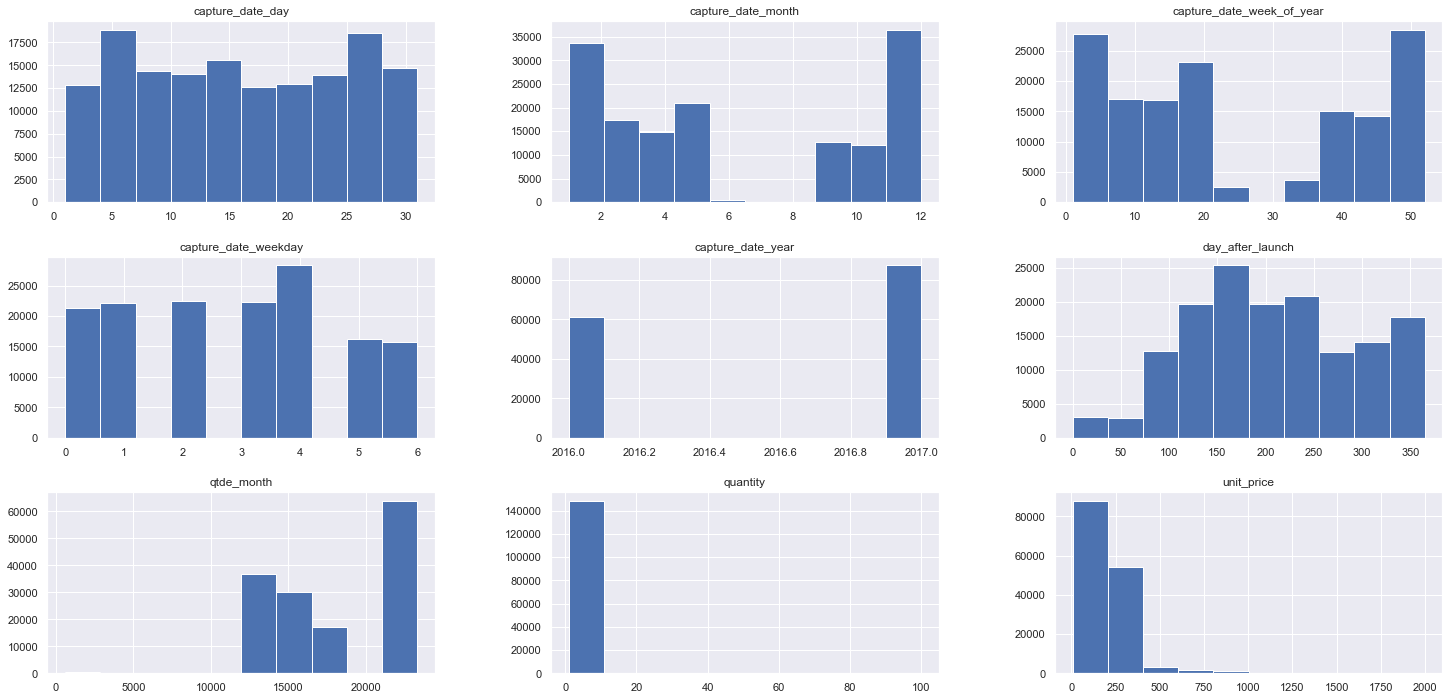

In [29]:
df4[['quantity', 'capture_date_year', 'capture_date_month', 'capture_date_day', 'capture_date_weekday', 'capture_date_week_of_year', 'day_after_launch', 'qtde_month', 'unit_price']].hist();

## 4.2. Analise Bivariada

### 4.2.1. Sales by Category during time

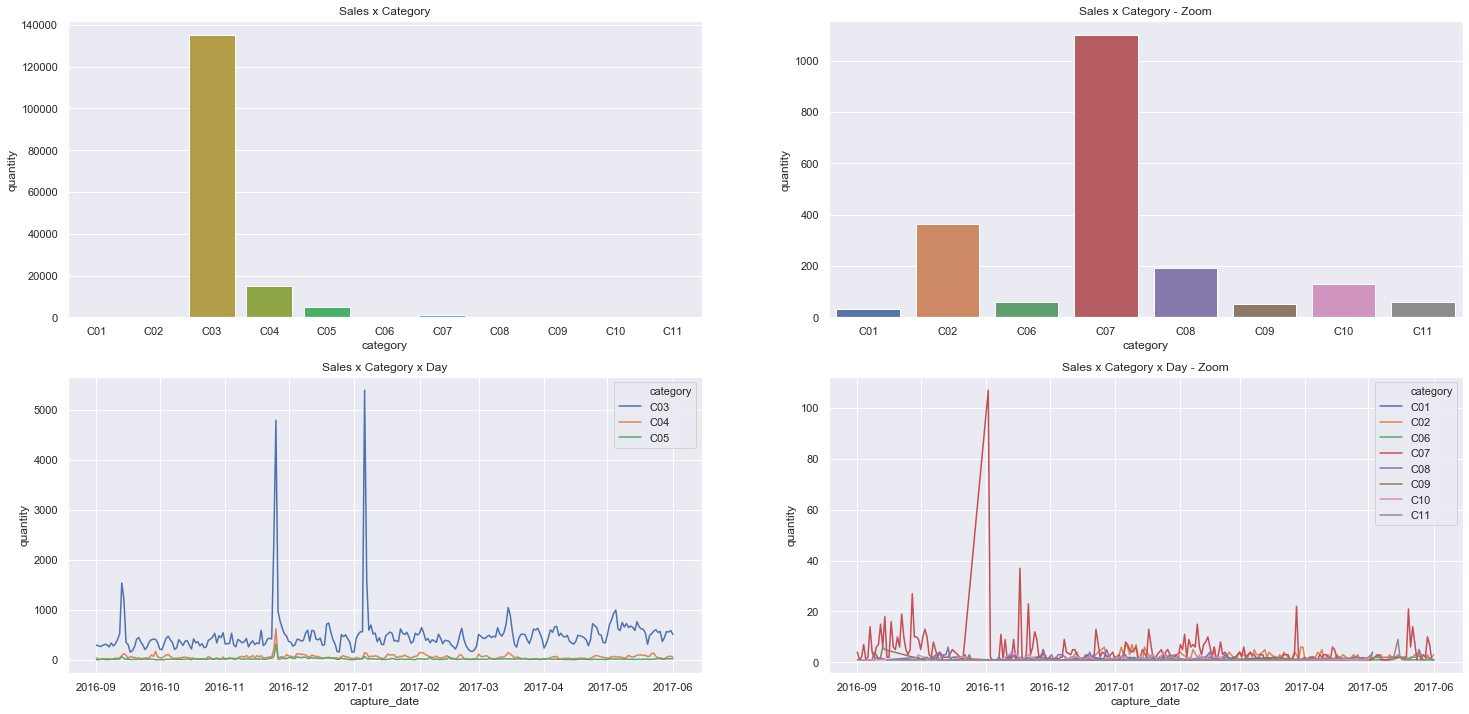

In [30]:
plt.subplot( 2, 2, 1 )
aux = df4[['category', 'quantity']].groupby( 'category' ).sum().reset_index();
sns.barplot( x='category', y='quantity', data=aux );
plt.title( 'Sales x Category')

plt.subplot( 2, 2, 2 )
aux = df4[['category', 'quantity']].groupby( 'category' ).sum().reset_index();
aux = aux[~aux['category'].isin( ['C03', 'C04', 'C05'] ) ];
sns.barplot( x='category', y='quantity', data=aux );
plt.title( 'Sales x Category - Zoom')

plt.subplot( 2, 2, 3 )
aux = df4[['category', 'capture_date', 'quantity']].groupby( ['category', 'capture_date'] ).sum().reset_index();
aux = aux[aux['category'].isin( ['C03', 'C04', 'C05'] ) ];
sns.lineplot( x='capture_date', y='quantity', hue='category', data=aux );
plt.title( 'Sales x Category x Day');


plt.subplot( 2, 2, 4 )
aux = df4[['category', 'capture_date', 'quantity']].groupby( ['category', 'capture_date'] ).sum().reset_index();
aux = aux[~aux['category'].isin( ['C03', 'C04', 'C05'] ) ];
sns.lineplot( x='capture_date', y='quantity', hue='category', data=aux );
plt.title( 'Sales x Category x Day - Zoom');

Text(0.5, 1.0, 'Sales x Category - Zoom')

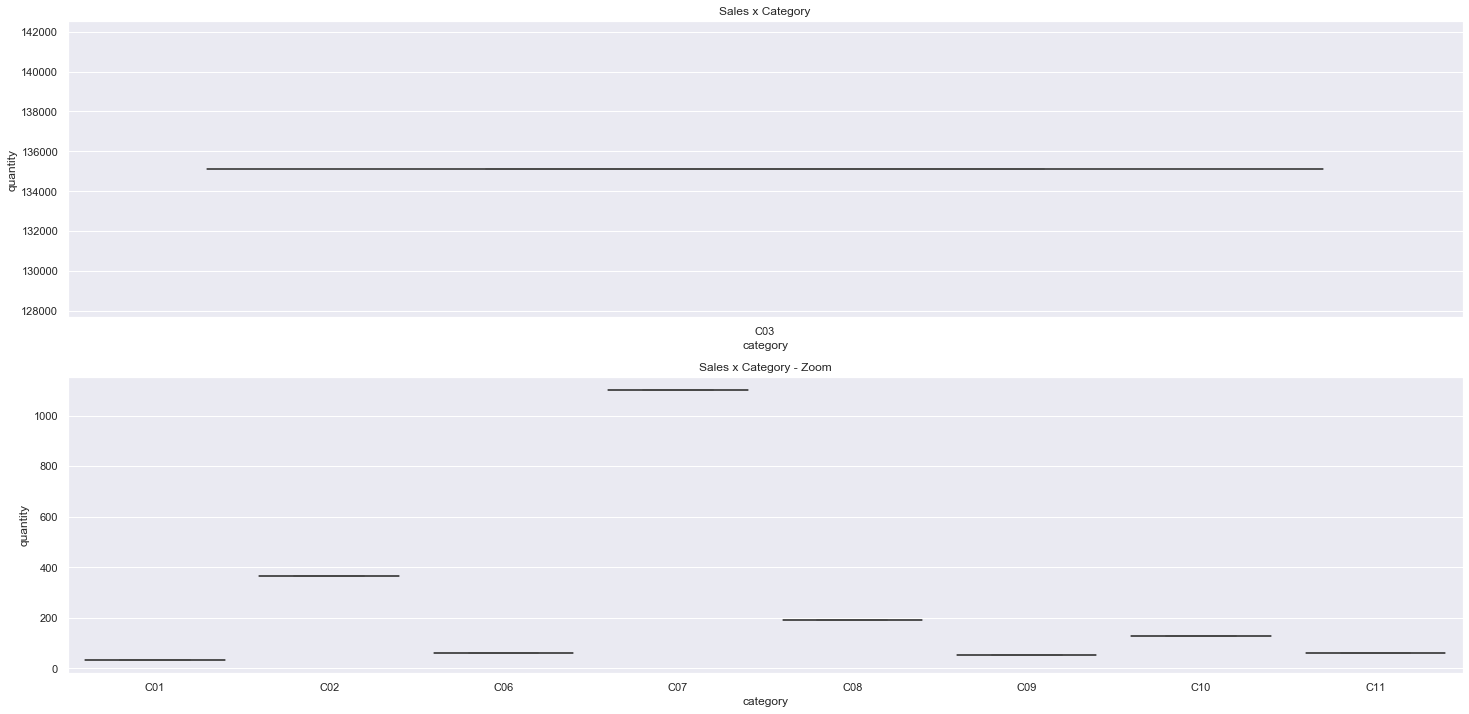

In [31]:
plt.subplot( 2, 1, 1 )
aux = df4[['category', 'quantity']].groupby( 'category' ).sum().reset_index();
aux = aux[aux['category'].isin( ['C03'] ) ];
sns.boxplot( x='category', y='quantity', data=aux );
plt.title( 'Sales x Category')

plt.subplot( 2, 1, 2 )
aux = df4[['category', 'quantity']].groupby( 'category' ).sum().reset_index();
aux = aux[~aux['category'].isin( ['C03', 'C04', 'C05'] ) ];
sns.boxplot( x='category', y='quantity', data=aux );
plt.title( 'Sales x Category - Zoom')

### 4.2.2. Sales by Type during time

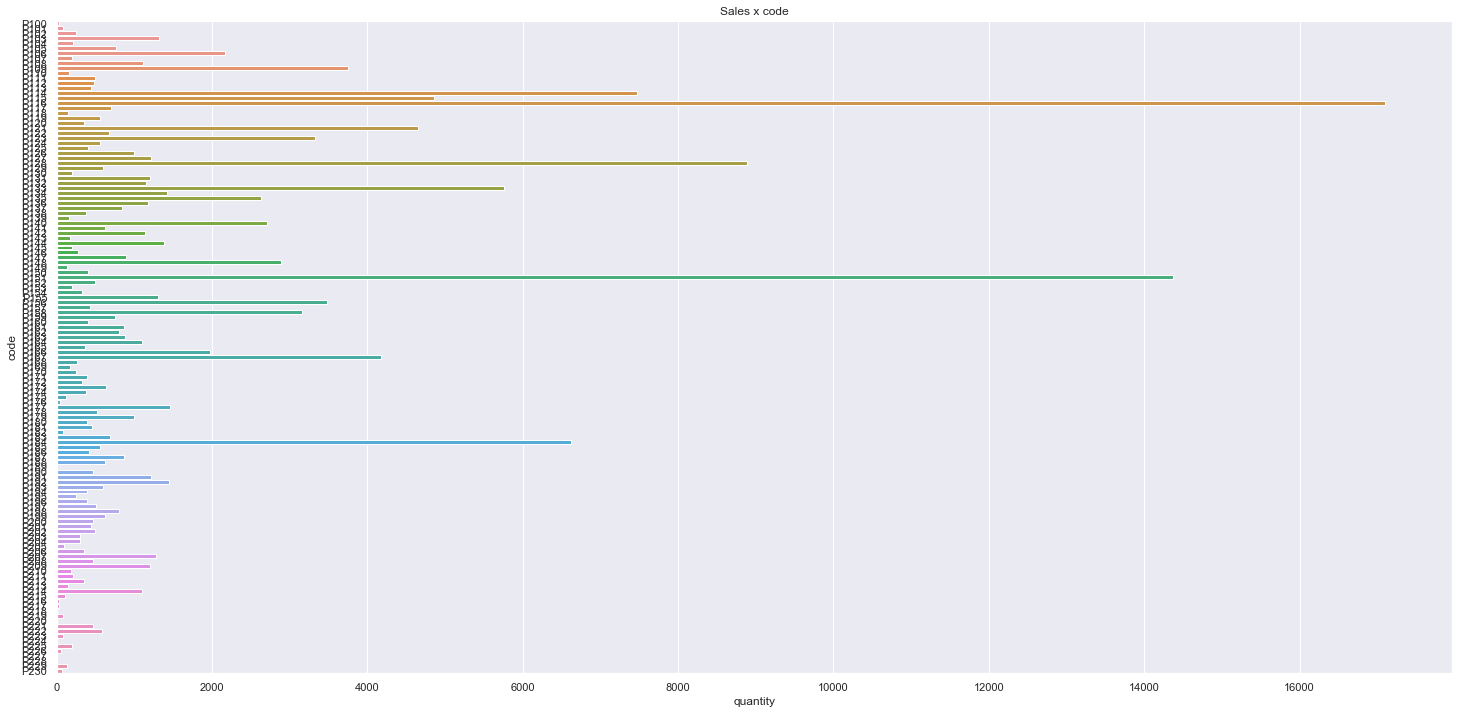

In [32]:
aux = df4[['code', 'quantity']].groupby( 'code' ).sum().reset_index();
sns.barplot( x='quantity', y='code', data=aux );
plt.title( 'Sales x code' );

### 4.2.2. Sales x Year, Month, Day, Year Week

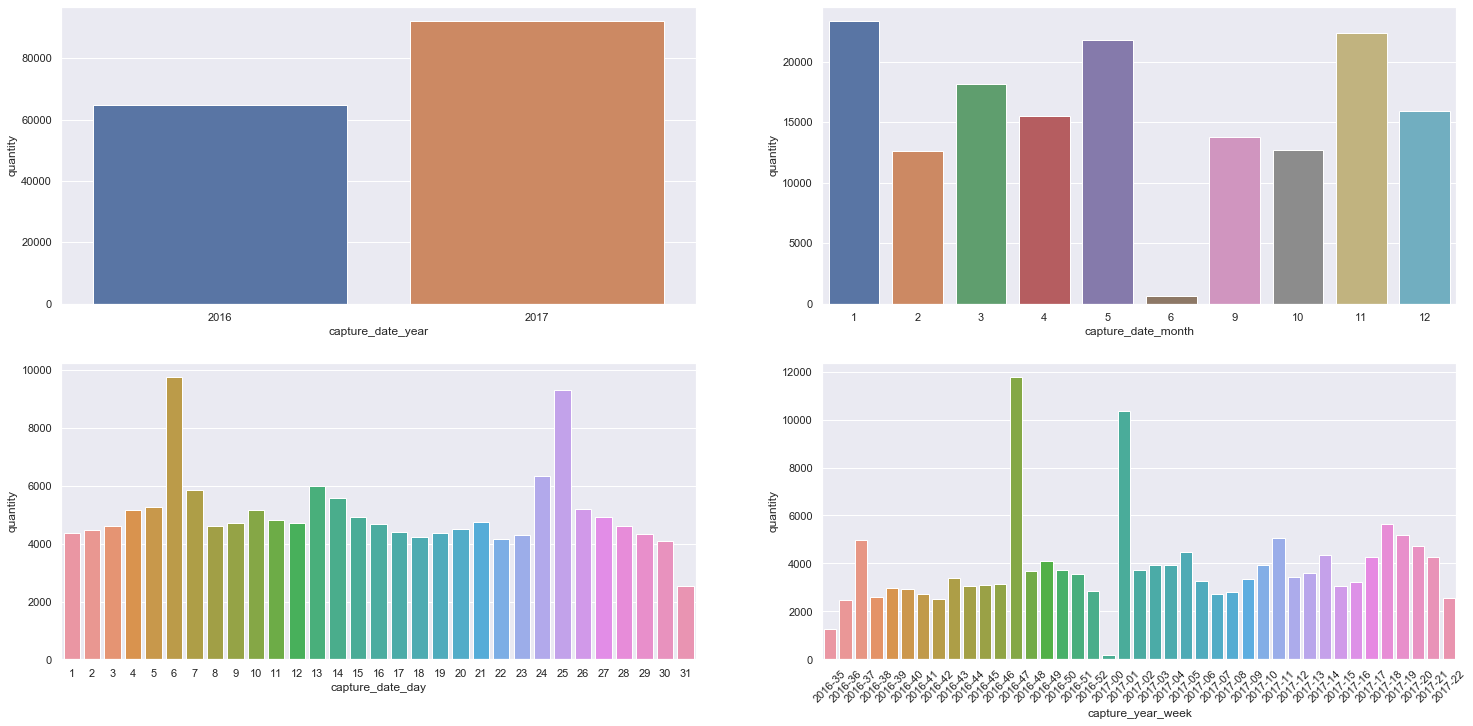

In [33]:
plt.subplot( 2, 2, 1 )
aux1 = df4[['capture_date_year', 'quantity']].groupby( 'capture_date_year' ).sum().reset_index()
sns.barplot( x='capture_date_year', y='quantity', data=aux1 );

plt.subplot( 2, 2, 2 )
aux1 = df4[['capture_date_month', 'quantity']].groupby( 'capture_date_month' ).sum().reset_index()
sns.barplot( x='capture_date_month', y='quantity', data=aux1 );

plt.subplot( 2, 2, 3 )
aux1 = df4[['capture_date_day', 'quantity']].groupby( 'capture_date_day' ).sum().reset_index()
sns.barplot( x='capture_date_day', y='quantity', data=aux1 );

plt.subplot( 2, 2, 4 )
aux2 = df4[['capture_year_week', 'quantity']].groupby( 'capture_year_week' ).sum().reset_index()
sns.barplot( x='capture_year_week', y='quantity', data=aux2 );
plt.xticks( rotation=45 );

### 4.2.2. Sales x Weekday, Day After Launch

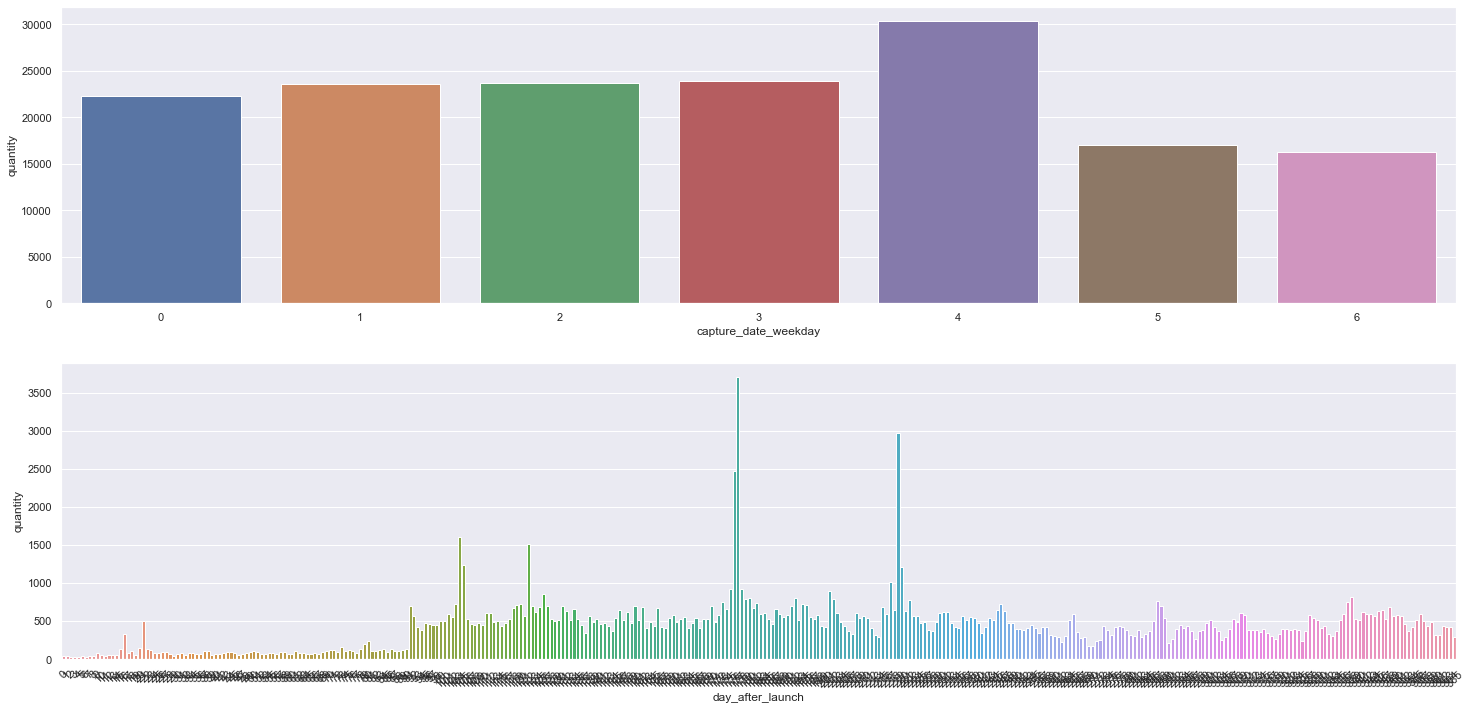

In [34]:
plt.subplot( 2, 1, 1 )
aux1 = df4[['capture_date_weekday', 'quantity']].groupby( 'capture_date_weekday' ).sum().reset_index()
sns.barplot( x='capture_date_weekday', y='quantity', data=aux1 );

plt.subplot( 2, 1, 2 )
aux1 = df4[['day_after_launch', 'quantity']].groupby( 'day_after_launch' ).sum().reset_index()
sns.barplot( x='day_after_launch', y='quantity', data=aux1 );
plt.xticks( rotation=45 );

### 4.2.3. Sales x Unit Price

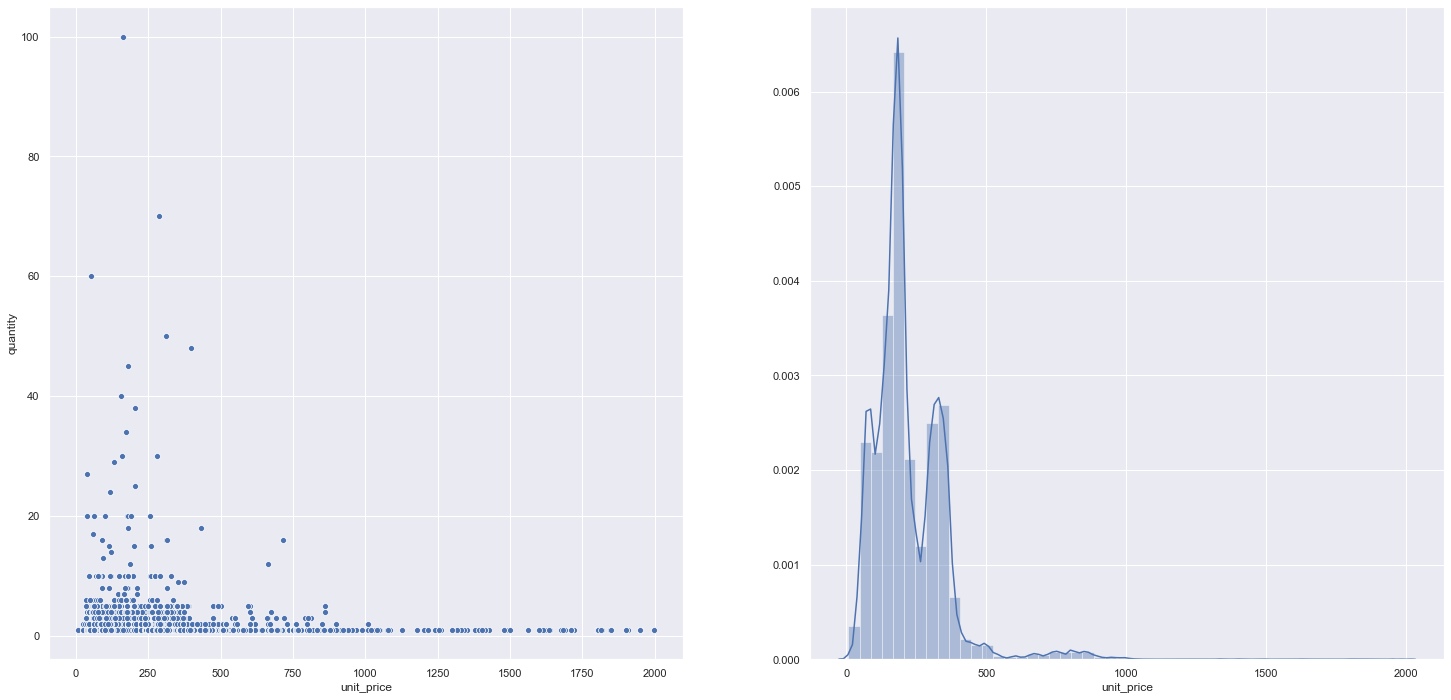

In [35]:
plt.subplot( 1, 2, 1 )
aux = df4[['quantity', 'unit_price']]
sns.scatterplot( x='unit_price', y='quantity', data=aux );

plt.subplot( 1, 2, 2)
sns.distplot( df4['unit_price'] );

## 4.3. Analise Multivariada

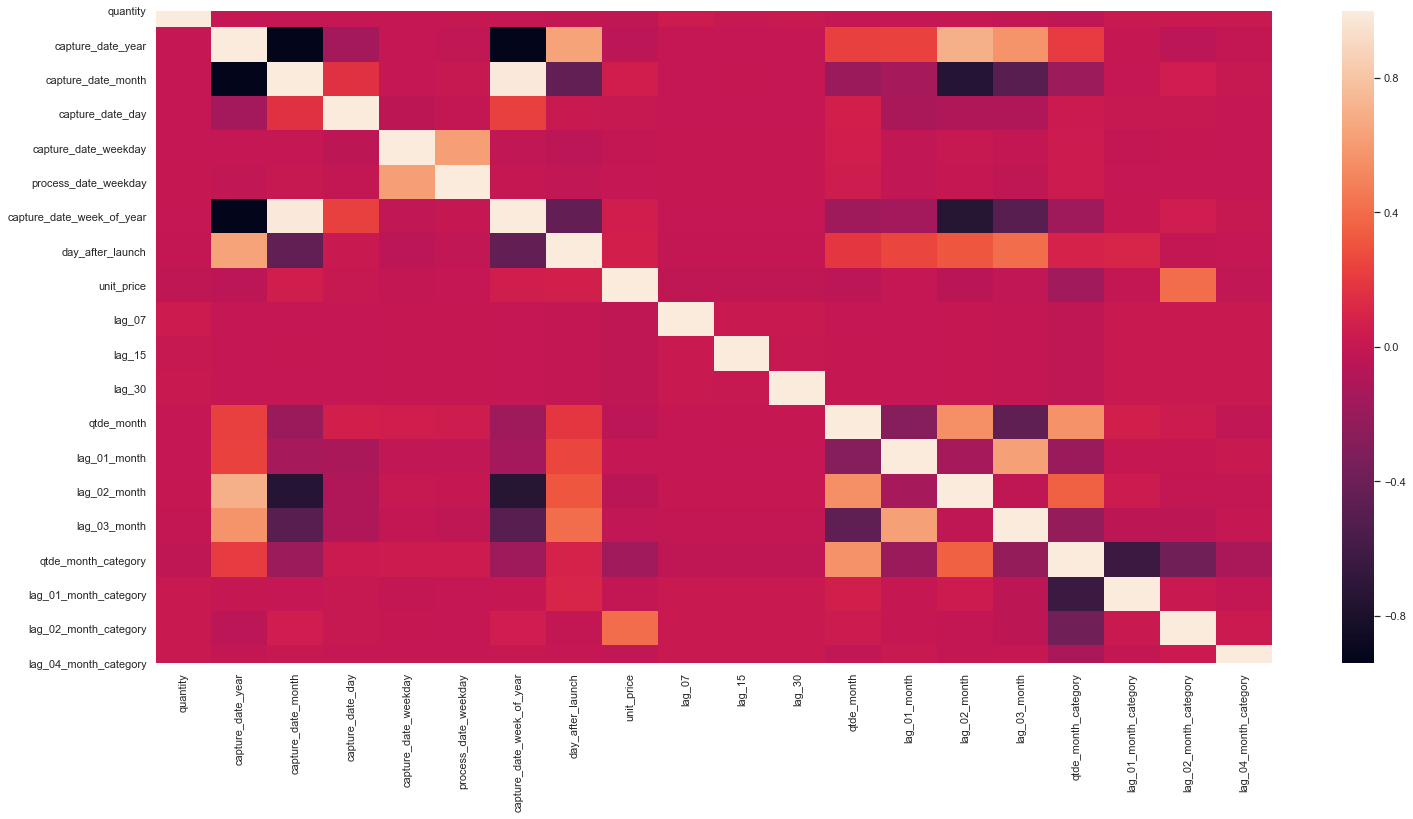

In [36]:
sns.heatmap( df4.drop( ['code', 'category', 'capture_date', 'capture_year_week'], axis=1 ).corr( method='pearson' ) )

# 5.0. DATA PREPARATION

In [37]:
df5 = df4.copy()

## 5.1. Import Marketing Data

In [39]:
# loading dataset
marketing_data = pd.read_csv( '../data/holiday_dates.csv' )

# drop index columns
marketing_data = marketing_data.drop( ['Unnamed: 0', 'holiday_name'], axis=1 )

# rename date to capture date
marketing_data = marketing_data.rename( columns={'date': 'capture_date'} )
marketing_data['capture_date'] = pd.to_datetime( marketing_data['capture_date'] )

# merge calendar date into main dataset
df5 = pd.merge( df5, marketing_data, how='left', on='capture_date' )
df5['event'] = df5['event'].replace( np.nan, 'regular', regex=True )

## 5.3. Encoding

In [40]:
# Target Encoding
df5['enc_category'] = calc_smooth_mean( df5, by='category', on='quantity', m=300 )

# Dummy Variables
df5 = pd.get_dummies( df5, columns=['event'] )

## 5.4. Transformação

In [41]:
# Unit Price
df5['enc_unit_price'] = np.log1p( df5['unit_price'] )

# month
df5['capture_date_month_sin'] = df5['capture_date_month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['capture_date_month_cos'] = df5['capture_date_month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['capture_date_day_sin'] = df5['capture_date_day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['capture_date_day_cos'] = df5['capture_date_day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# weekday
df5['capture_date_weekday_sin'] = df5['capture_date_weekday'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['capture_date_weekday_cos'] = df5['capture_date_weekday'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# week of year
df5['capture_date_week_of_year_sin'] = df5['capture_date_week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['capture_date_week_of_year_cos'] = df5['capture_date_week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0. FEATURE SELECTION

In [42]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [43]:
# training dataset
X_train = df6[df6['capture_date'] < '2017-03-01']
y_train = X_train['quantity']

# test dataset
X_test = df6[df6['capture_date'] >= '2017-03-01']
y_test = X_test['quantity']

print( 'Training Min Date: {}'.format( X_train['capture_date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['capture_date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['capture_date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['capture_date'].max() ) )

Training Min Date: 2016-09-01 00:00:00
Training Max Date: 2017-02-28 00:00:00

Test Min Date: 2017-03-01 00:00:00
Test Max Date: 2017-06-01 00:00:00


## 6.2. Boruta algorithms

In [51]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['code', 'category', 'capture_date', 'capture_year_week', 'quantity'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

KeyboardInterrupt: 

### 6.2.1. Best Features from Boruta

In [ ]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [52]:
cols_selected_boruta = [
    'capture_date_year',
    'capture_date_month_sin',
    'capture_date_month_cos',
    'capture_date_day_sin',
    'capture_date_day_cos',
    'day_after_launch',
    'capture_date_week_of_year_sin',
    'capture_date_week_of_year_cos',
    'enc_unit_price',
    'qtde_month',
    'lag_01_month',
    'lag_02_month',
    'lag_03_month',
    'qtde_month_category',
    'lag_01_month_category',
    'lag_02_month_category',
    'lag_04_month_category',
    'enc_category',
    'event_blackFriday',
    'event_cybermonday',
    'event_holiday',
    'event_regular',
]


# columns to add
feat_to_add = ['code', 'capture_date_month', 'capture_date', 'quantity']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. MACHINE LEARNING MODELLING

In [53]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# data preparation for cross-validation
x_training = X_train[ cols_selected_boruta_full ]
x_training = x_training.drop( 'code', axis=1 )

## 7.1. Average Model

In [54]:
aux1 = X_test.copy()
aux1['quantity'] = y_test.copy()

# prediction
aux2 = aux1[['code', 'quantity']].groupby( 'code' ).mean().reset_index().rename( columns={'quantity': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='code' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', y_test, yhat_baseline ) 
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,0.087534,0.062919,0.550058


## 7.2. Linear Regression Model

In [55]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', y_test, yhat_lr )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,0.104464,0.074656,0.553438


### 7.2.1. Linear Regression Model - Cross Validation

In [56]:
lr_result_cv = cross_validation( x_training, 3, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,36616943685.67 +/- 50325325825.1,35989512456.16 +/- 49469544951.02,37327064450.06 +/- 51309815157.76


## 7.3. Linear Regression Model - Lasso

In [57]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', y_test, yhat_lrr )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,0.090431,0.06034,0.552714


### 7.3.1. Lasso Linear Regression Model - Cross Validation

In [58]:
lrr_result_cv = cross_validation( x_training, 3, 'Linear Regression Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Lasso,0.11 +/- 0.02,0.07 +/- 0.02,0.58 +/- 0.09


## 7.4. Random Forest Regressor

In [59]:
# model
rf = RandomForestRegressor( n_estimators=500, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', y_test, yhat_rf )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,0.294769,0.265831,1.198016


### 7.4.1. Random Forest Regressor - Cross Validation

In [60]:
rf_result_cv = cross_validation( x_training, 3, 'Random Forest', rf, verbose=False )
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,0.24 +/- 0.04,0.2 +/- 0.04,0.82 +/- 0.16


## 7.5. XGBoost Regressor

In [61]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=500, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', y_test, yhat_xgb )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,0.310042,0.280408,1.242488


### 7.5.1. XGBoost Regressor - Cross Validation

In [62]:
xgb_result_cv = cross_validation( x_training, 3, 'XGBoost', model_xgb, verbose=False )
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,0.34 +/- 0.08,0.3 +/- 0.08,0.96 +/- 0.19


## 7.6. Compare Model Performance

### 7.6.1. Single Performance

In [63]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Average Model,0.087534,0.062919,0.550058
0,Linear Regression - Lasso,0.090431,0.060340,0.552714
0,Linear Regression,0.104464,0.074656,0.553438
0,Random Forest Regressor,0.294769,0.265831,1.198016
0,XGBoost Regressor,0.310042,0.280408,1.242488


### 7.6.2. Real Performance - Cross Validation

In [64]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,36616943685.67 +/- 50325325825.1,35989512456.16 +/- 49469544951.02,37327064450.06 +/- 51309815157.76
0,Linear Regression Lasso,0.11 +/- 0.02,0.07 +/- 0.02,0.58 +/- 0.09
0,Random Forest,0.24 +/- 0.04,0.2 +/- 0.04,0.82 +/- 0.16
0,XGBoost,0.34 +/- 0.08,0.3 +/- 0.08,0.96 +/- 0.19


# 8.0 HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [75]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'max_depth': [3, 5, 9],
        }

MAX_EVAL = 5

In [76]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_rf = RandomForestRegressor( n_estimators=hp['n_estimators'], 
                                      max_depth=hp['max_depth'], 
                                      n_jobs=-1, random_state=42 ).fit( x_train, y_train )

    # performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_rf, verbose=True )
    final_result = pd.concat( [final_result, result] )
        
final_result

{'n_estimators': 3500, 'max_depth': 3}


KeyboardInterrupt: 

In [ ]:
final_result

## 8.2. Final Model

In [77]:
param_tuned = {
    'n_estimators': 500,
    'max_depth': 3,
        }


In [78]:
# model
model_rf_tuned = RandomForestRegressor( n_estimators=500, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf_tuned = model_rf_tuned.predict( x_test )

# performance
rf_result_tuned = ml_error( 'Random Forest Regressor', y_test, yhat_rf_tuned )
rf_result_tuned

KeyboardInterrupt: 

# 9.0. ERROR UNDERSTANDING

In [79]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['predictions'] = np.round( yhat_rf, 0 )

# compute error and error_rate
df9['error'] = df9['quantity'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['quantity']

## 9.1. Business Performance

### 9.1.1. Business Performance - Table Results

In [80]:
aux = df9[['code', 'capture_date_year', 'capture_date_month', 'quantity', 'predictions', 'error']].groupby( ['code', 'capture_date_year', 'capture_date_month'] ).sum().reset_index()
aux.sort_values( ['code', 'capture_date_month'] ).head(6)

,code,capture_date_year,capture_date_month,quantity,predictions,error
0,P100,2017,3,3,4.0,-1.0
1,P100,2017,4,5,5.0,0.0
2,P100,2017,5,6,6.0,0.0
3,P101,2017,3,11,11.0,0.0
4,P101,2017,4,2,3.0,-1.0
5,P101,2017,5,6,5.0,1.0


### 9.1.2. Business Performance - Plot Results

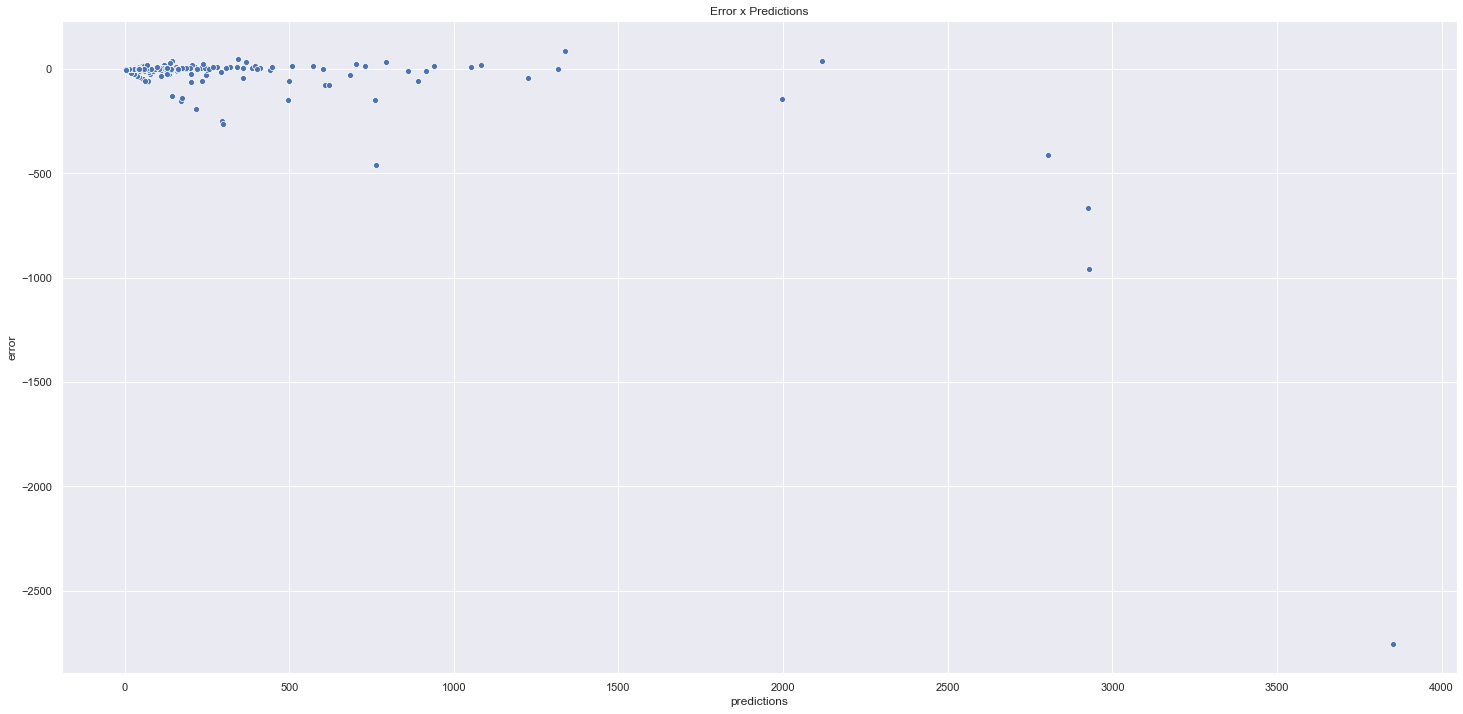

In [81]:
sns.scatterplot( aux['predictions'], aux['error'] )
plt.title( 'Error x Predictions' );

## 9.2. Machine Learning Performance

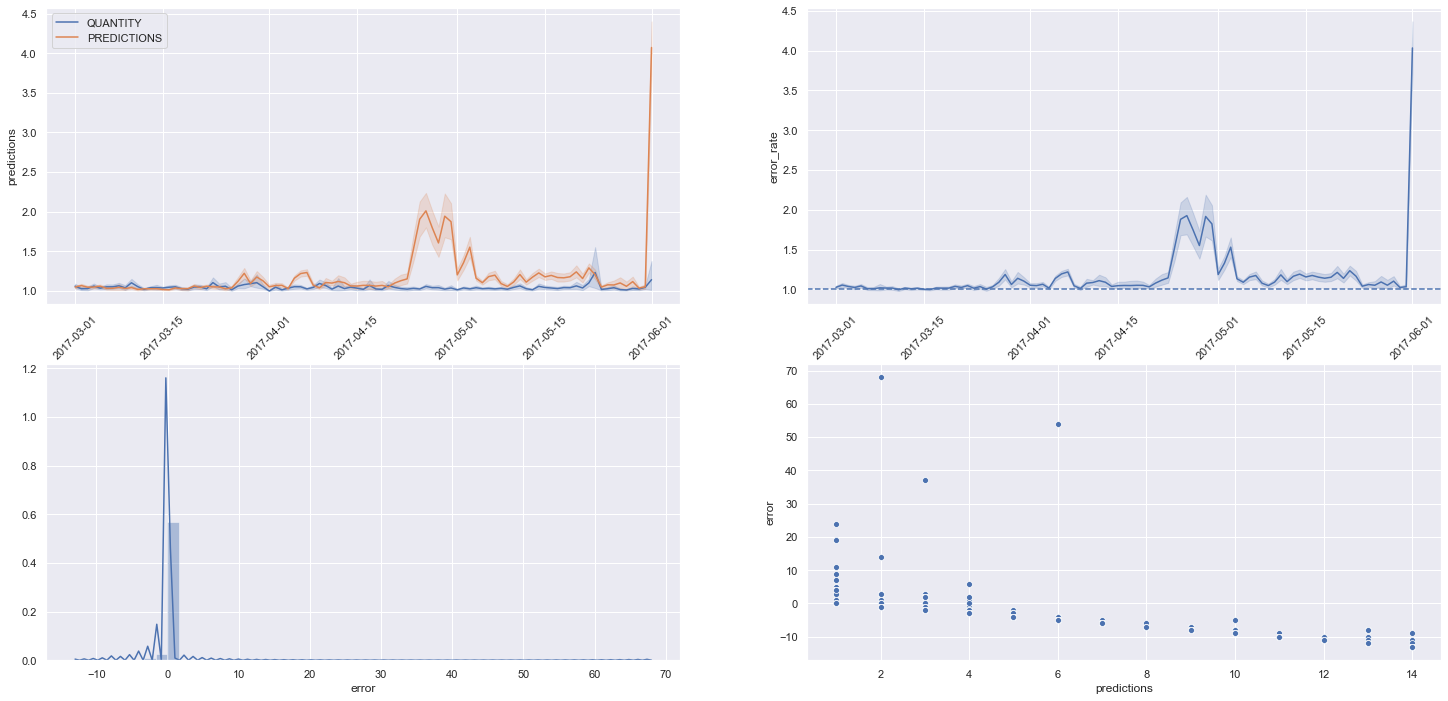

In [82]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='capture_date', y='quantity', data=df9, label='QUANTITY' )
sns.lineplot( x='capture_date', y='predictions', data=df9, label='PREDICTIONS' )
plt.xticks( rotation=45 );

plt.subplot( 2, 2, 2 )
sns.lineplot( x='capture_date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')
plt.xticks( rotation=45 );

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

## 9.3. Error Investigating